# Anomaly Detection with Auto-encoder

### Import required modules and libraries

In [291]:
import os
import torch
import torch.nn as neuralnet
import torch.optim as optimizer
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy as sp

from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from torchsummary import summary

#use pip install torchsummary to install torchsummary
#use conda install scipy to install scipy

In [266]:
# Find pyTorch device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Load and visualize MNIST dataset (using torchvision)

No. of Training images: 60000
No. of Test images:  10000
Batch size:  50
Number of batches (train set): 1200


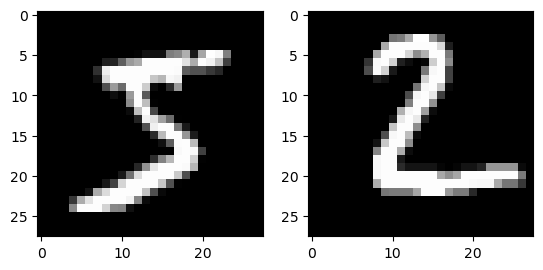

In [267]:
# Define transform to transform image to tensor
transform_to_tensor = transforms.ToTensor()

# Initialize MNIST train and test data from PyTorch
mnist_train = datasets.MNIST(root='./data', train= True, download = True, transform = transform_to_tensor)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform = transform_to_tensor)

# Split the training data into mini-batches along with shuffling (to prevent over-fitting) using DataLoader iterable
batch_size = 50     # Setting up batch size
data_train = DataLoader(dataset=mnist_train, batch_size = batch_size, shuffle= True)


# Print the dimensions of loaded data set
print('No. of Training images:', len(mnist_train))
print('No. of Test images: ', len(mnist_test) )
print('Batch size: ', batch_size)
print('Number of batches (train set):', len(data_train))

# Visualize a train and test images loaded from MNIST dataset
fig, [ax1, ax2] = plt.subplots(1, 2)
x, _ = mnist_train[0]
ax1.imshow(x.numpy()[0], cmap='gray')
x, _ = mnist_test[1]
ax2.imshow(x.numpy()[0], cmap='gray')
plt.show()


## 1. Implementation

### 1.1 Encoder and Decoder parts (Based on MLP)

In [268]:
class Auto_Encoder(neuralnet.Module):
    def __init__(self):
        super().__init__()

        # Encoder architecture
        self.encoder = neuralnet.Sequential(
            # Input dimension: N, 28*28
            neuralnet.Linear(28*28, 256),   # N, 784 -> N, 256
            neuralnet.ReLU(),
            neuralnet.Linear(256, 64),      # N, 256 -> N, 64
            neuralnet.ReLU(),
            neuralnet.Linear(64,8)          # N, 64  -> N, 8
        )   # Output dimension: N, 8

        # Decoder architecture
        self.decoder = neuralnet.Sequential(
            neuralnet.Linear(8, 64),        # N, 8  -> N, 64
            neuralnet.ReLU(),
            neuralnet.Linear(64, 256),      # N, 64 -> N, 256
            neuralnet.ReLU(),
            neuralnet.Linear(256, 28*28),   # N, 256 -> N, 784
            neuralnet.Sigmoid()
        )

    def forward(self, data):
        encoded_data = self.encoder(data)
        decoded_data = self.decoder(encoded_data)
        return decoded_data

# Create an instance of our model and move it to corresponding pytorch device
model = Auto_Encoder()


#### 1.2 Define Mean Squared Error (MSE) loss function

In [269]:
loss_function = neuralnet.MSELoss()

#### 1.3 Define Stochastic Gradient Descent for Optimization

In [270]:
sgd = torch.optim.SGD(model.parameters(), lr=1, momentum = 0.9)

#### Train the Auto Encoder using training set

In [271]:

# Define number of epochs over which the model has to be trained
epochs = 10
# Create an output list to store the processed images
output = []
print('Training using MNIST train dataset: ')
for epoch in range(epochs):
    for (image, _) in data_train:
        image = image.reshape(-1, 28*28)    # flattening the image
        processed_image = model(image)
        loss = loss_function(processed_image, image)

        sgd.zero_grad()
        loss.backward()
        sgd.step()
    
    print(f'Epoch {epoch+1}, Loss (MSE): {loss.item()}')
    output.append((epoch, image, processed_image))

Training using MNIST train dataset: 
Epoch 1, Loss (MSE): 0.03680189326405525
Epoch 2, Loss (MSE): 0.02459239773452282
Epoch 3, Loss (MSE): 0.02353893592953682
Epoch 4, Loss (MSE): 0.019808446988463402
Epoch 5, Loss (MSE): 0.018021810799837112
Epoch 6, Loss (MSE): 0.020443536341190338
Epoch 7, Loss (MSE): 0.01959170773625374
Epoch 8, Loss (MSE): 0.01819510944187641
Epoch 9, Loss (MSE): 0.017200494185090065
Epoch 10, Loss (MSE): 0.016215452924370766


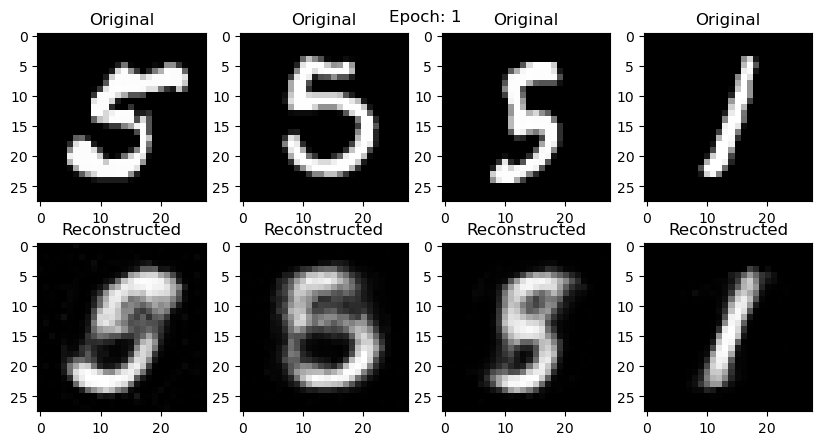

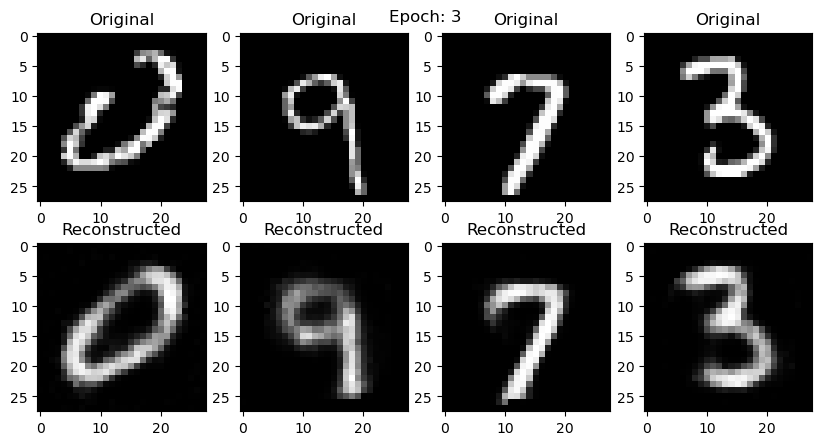

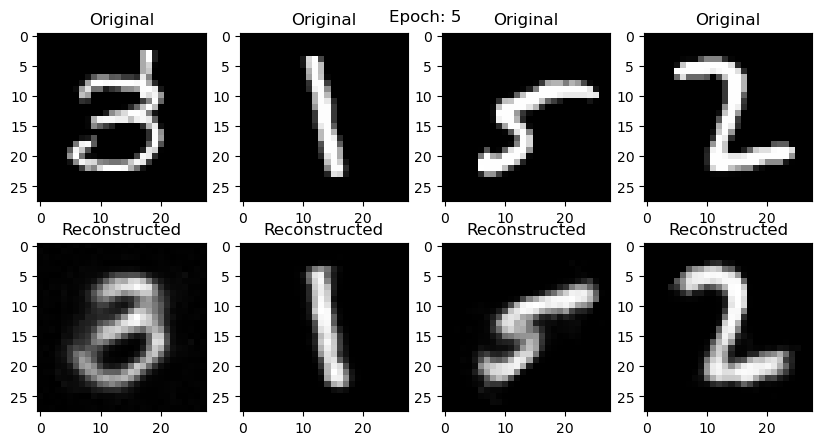

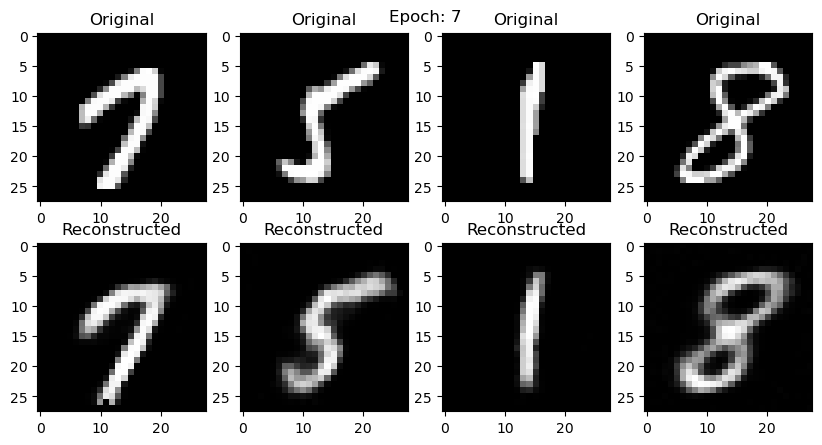

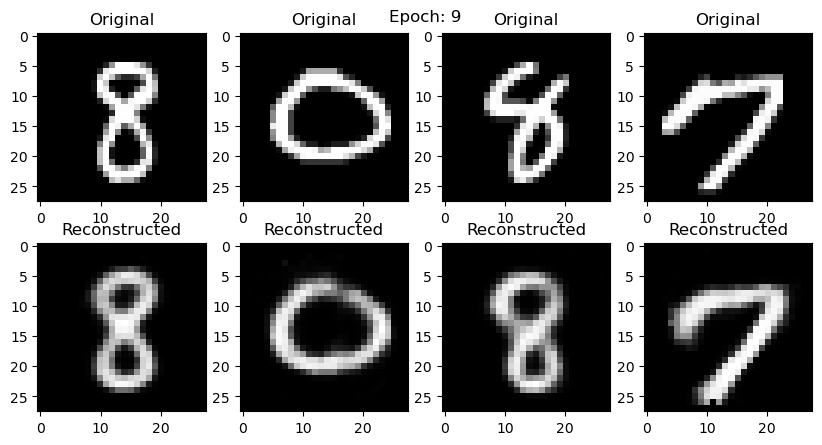

In [272]:
# Visualize original images and reconstructed images generated by Auto-Encoder

for i in range(0,epoch,2):
    plt.figure(figsize = (10,5))
    plt.gray()                              
    images = output[i][1].detach()
    reconstructed_images = output[i][2].detach()
    plt.gca().set_title(f'Epoch: {i+1}')
    plt.axis('off')
    
    #Plot original images
    for j, item in enumerate(images):
        if(j>=4):
            break
        plt.subplot(2, 4, j+1)
        plt.gca().set_title('Original')
        item = item.reshape(-1, 28, 28)     # Reshape the flattened image
        plt.imshow(item[0])    
    
    #Plot reconstructed image
    for j, item in enumerate(reconstructed_images):
        if(j>=4):
            break
        plt.subplot(2, 4, 4+j+1)
        plt.gca().set_title('Reconstructed')
        item = item.reshape(-1, 28, 28)     # Reshape the flattened image
        plt.imshow(item[0])   

We can observe the quality of reconstructed image improves with increasing epochs from above visuals

### Testing the Auto-Encoder model

Loss (MSE) of simple auto-encoder on test set:  0.01668611727654934


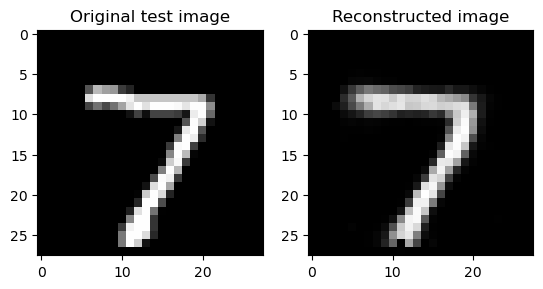

In [273]:
# Testing the model with normal images

# Load test data
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform = transform_to_tensor)
data_test = DataLoader(dataset=mnist_test, batch_size = 50)

output = []
for (image, _) in data_test:
    image = image.reshape(-1, 28*28)    # flattening the image
    reconstructed_image = model(image)  # Using the trained model for reconstruction of the image
    loss = loss_function(reconstructed_image, image)
    output.append(reconstructed_image)
print('Loss (MSE) of simple auto-encoder on test set: ', loss.item())


# Plotting samples of original and reconstructed image

# Plotting original image
fig, ax = plt.subplots(1, 2)
img, _ = mnist_test[0]
ax[0].imshow(img.numpy()[0], cmap='gray')
ax[0].set_title('Original test image')

# Plotting the reconstructed image
img = output[0]  
img = img.reshape(-1, 28, 28)     # Reshape the flattened image
ax[1].imshow(img.detach().numpy()[0], cmap='gray')
ax[1].set_title('Reconstructed image')
plt.show()

## 2 Questions

### 1. Take a subset (10%) of the MNIST test dataset and add excessive noise to corrupt images. Then, visualize four samples for original and corrupted ones. Note: The type of noise is optional. Be sure that the amount of noise is enough for finding outliers (anomalies) in question 8 with the help of the threshold value.

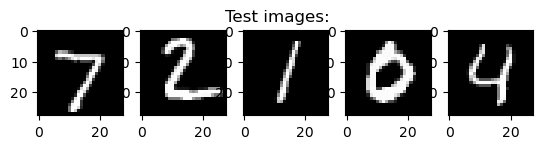

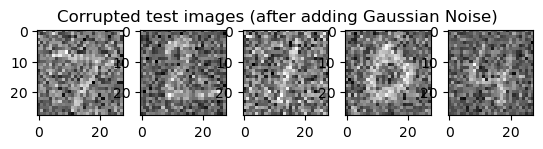

In [290]:

# Load MNIST test data
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_to_tensor)
# Choose first 10% images of MNIST test set
subset_test = Subset(mnist_test, indices=range(len(mnist_test)//10))

# Class for Gaussian noise
class GaussianNoise:
    def __init__(self, mean = 0.0, std = 0.5 ):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# The amount of Gaussian noise to be added to the images can be controlled by changing the below mean and std
mean = 0.0
std = 0.5

# Transform to add Gaussian noise to images
noise_transform = transforms.Compose([
    transforms.ToTensor(),
    GaussianNoise(mean, std)
])

mnist_test_noise = datasets.MNIST(root='./data', train=False, download=True, transform = noise_transform)

# 2.1 Choose first 10% images after applying new noise_transform
subset_test_noise = Subset(mnist_test_noise, indices=range(len(mnist_test_noise)//10))


# Print n original and noisy images
n=5
fig, ax = plt.subplots(1, n)
for i in range(n):
    img, _ = subset_test[i]     
    ax[i].imshow(img.numpy()[0], cmap='gray')
plt.title('Test images:', x = -2)

fig, ax = plt.subplots(1, n)
for i in range(n):
    img, _ = subset_test_noise[i]     
    ax[i].imshow(img.numpy()[0], cmap='gray')
plt.title('Corrupted test images (after adding Gaussian Noise)', x=-2)
plt.show()

### 2. Train your autoencoder architecture by using the MNIST training dataset. Obtain the autoencoder output generated from corrupted input test images and not corrupted test images. Compare those results with original and corrupted test images. Comment on the results. What did you expect, and what did you observe? What are the reasons for similarities and differences?

Loss (MSE) for noisy test set:  0.27390748262405396


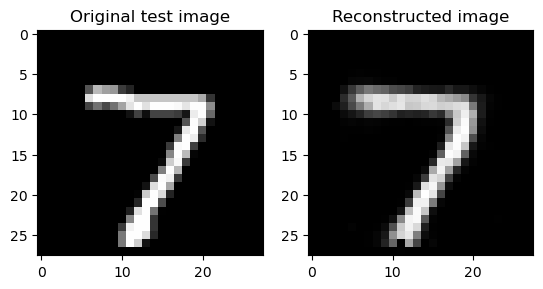

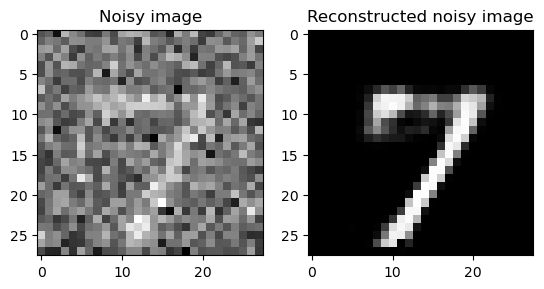

In [275]:
# Load test data
data_test = DataLoader(dataset=mnist_test, batch_size = 50)
data_test_noise = DataLoader(dataset=mnist_test_noise, batch_size = 50)

output = []
for (image, _) in data_test:
    image = image.reshape(-1, 28*28)    # flattening the image
    reconstructed_image = model(image)  # Using the trained model for reconstruction of the image
    output.append(reconstructed_image)

output_noisy = []
for (image, _) in data_test_noise:
    image = image.reshape(-1, 28*28)    # flattening the image
    reconstructed_image = model(image)  # Using the trained model for reconstruction of the image
    loss = loss_function(reconstructed_image, image)
    output_noisy.append(reconstructed_image)

print('Loss (MSE) for noisy test set: ', loss.item())

# Plotting original and reconstructed image

# Plotting original image
fig, ax = plt.subplots(1, 2)
img, _ = mnist_test[0]
ax[0].imshow(img.numpy()[0], cmap='gray')
ax[0].set_title('Original test image')

# Plotting the reconstructed image
img = output[0]  
img = img.reshape(-1, 28, 28)     # Reshape the flattened image
ax[1].imshow(img.detach().numpy()[0], cmap='gray')
ax[1].set_title('Reconstructed image')

# Plotting original noisy image
fig, ax = plt.subplots(1, 2)
img, _ = mnist_test_noise[0]
ax[0].imshow(img.numpy()[0], cmap='gray')
ax[0].set_title('Noisy image')

# Plotting the reconstructed noisy image
img = output_noisy[0]  
img = img.reshape(-1, 28, 28)     # Reshape the flattened image
ax[1].imshow(img.detach().numpy()[0], cmap='gray')
ax[1].set_title('Reconstructed noisy image')

plt.show()

Inference: From the above images, the quality of the reconstructed image decreases after incorporating noise to original (input) images. But, the auto-encoder produced the expected digit as present in the input, even in the presence of noise. But if we increase (noise) by varying the mean or standard deviation of the Gaussian, then the auto-encoder fails to reconstruct the same digit. This is because, in presence of high noise, the network may focus on the noise rather than detecting the required features. Thus, the auto-encoder performs in a poor way to unseen test images with noise.

### 3. What happens if your dataset includes corrupted images not only in the testing dataset but also in the training dataset? How does it affect the performance of the model?

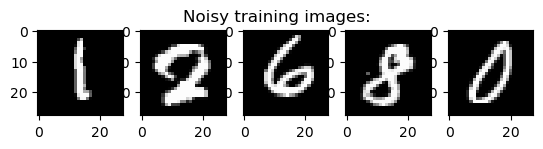

In [276]:
mnist_train = datasets.MNIST(root='./data', train= True, download = True, transform = transform_to_tensor)
# Generate noisy dataset
mnist_train_noisy = datasets.MNIST(root='./data', train=True, download=True, transform = noise_transform) 

# Choose first 50% images of original set and noisy set 
subset_train = Subset(mnist_train, indices=range(len(mnist_train)//2))
subset_train_noisy = Subset(mnist_train_noisy, indices=range(len(mnist_train)//2))

# Create dataset containing normal training images and noisy images
noisy_dataset = subset_train + subset_train_noisy
noisy_train = DataLoader(dataset=noisy_dataset, batch_size = 50, shuffle= True)


# Plot some images from noisy_dataset which includes corrupted images
l = list(noisy_dataset)
random.shuffle(l)
n=5
fig, ax = plt.subplots(1, n)
for i in range(n):
    img, _ = l[i]     
    ax[i].imshow(img.numpy()[0], cmap='gray')
plt.title('Noisy training images:', x = -2)
plt.show()


Training using noisy dataset: 
Epoch 1, Loss (MSE): 0.1746188849210739
Epoch 2, Loss (MSE): 0.13101845979690552
Epoch 3, Loss (MSE): 0.14660978317260742
Epoch 4, Loss (MSE): 0.13214270770549774
Epoch 5, Loss (MSE): 0.15728332102298737
Epoch 6, Loss (MSE): 0.13191919028759003
Epoch 7, Loss (MSE): 0.1204342246055603
Epoch 8, Loss (MSE): 0.1408863365650177
Epoch 9, Loss (MSE): 0.13411734998226166
Epoch 10, Loss (MSE): 0.13948951661586761


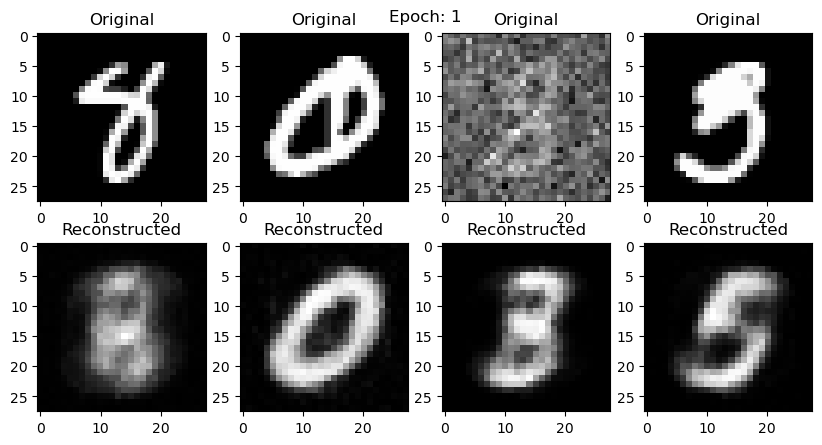

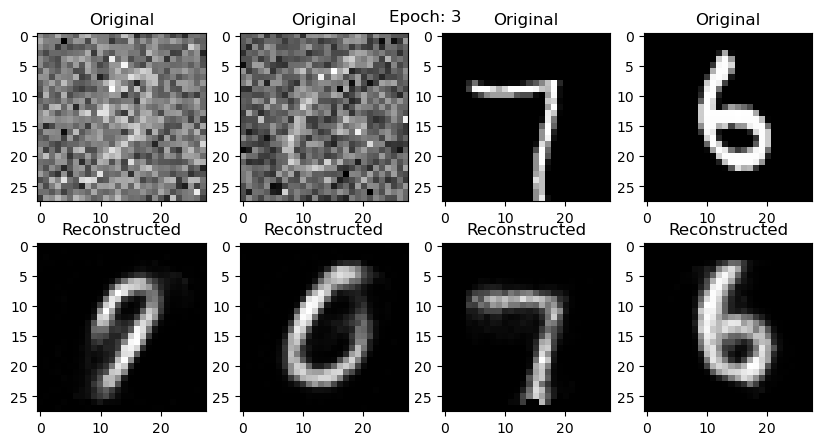

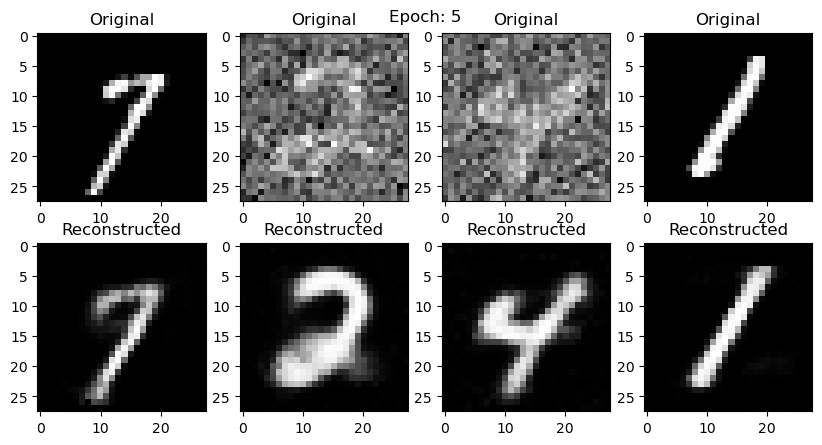

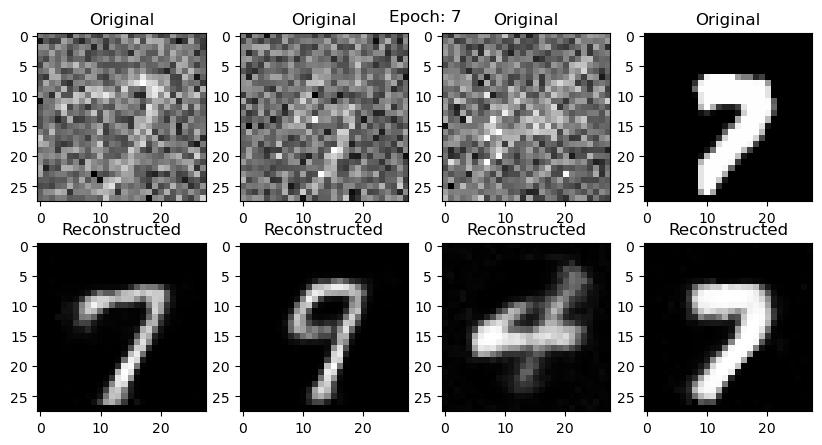

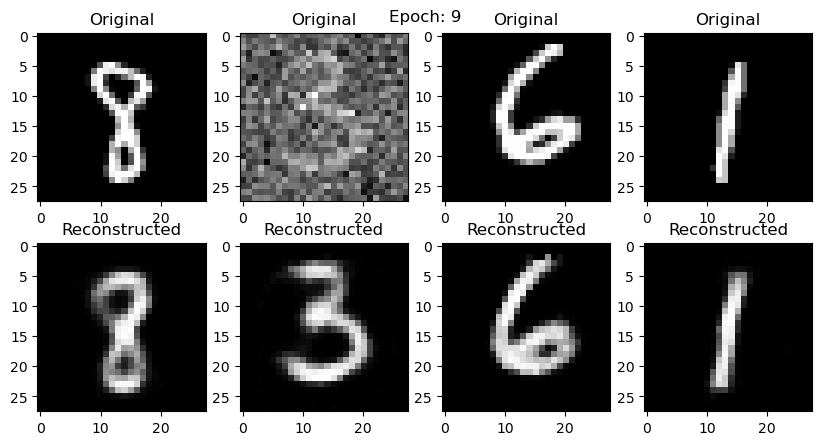

In [277]:
# Create new instance of model
model = Auto_Encoder()

loss_function = neuralnet.MSELoss()
sgd = torch.optim.SGD(model.parameters(), lr = 1, momentum = 0.9)

# Train Autoencoder on above corrupted data (noisy_train)
epochs = 10
output = []

print('Training using noisy dataset: ')
for epoch in range(epochs):
    for (image, _) in noisy_train:
        image = image.reshape(-1, 28*28)    # flattening the image
        reconstructed_image = model(image)
        loss = loss_function(reconstructed_image, image)

        sgd.zero_grad()
        loss.backward()
        sgd.step()
    
    print(f'Epoch {epoch+1}, Loss (MSE): {loss.item()}')
    output.append((epoch, image, reconstructed_image))


# Plot original and reconstructed images along some epochs

for i in range(0,epoch,2):
    plt.figure(figsize = (10,5))
    plt.gray()                              
    images = output[i][1].detach()
    reconstructed_images = output[i][2].detach()
    plt.gca().set_title(f'Epoch: {i+1}')
    plt.axis('off')
    
    #Plot original images
    for j, item in enumerate(images):
        if(j>=4):
            break
        plt.subplot(2, 4, j+1)
        plt.gca().set_title('Original')
        item = item.reshape(-1, 28, 28)     # Reshape the flattened image
        plt.imshow(item[0])    
    
    #Plot reconstructed image
    for j, item in enumerate(reconstructed_images):
        if(j>=4):
            break
        plt.subplot(2, 4, 4+j+1)
        plt.gca().set_title('Reconstructed')
        item = item.reshape(-1, 28, 28)     # Reshape the flattened image
        plt.imshow(item[0])  

Loss (MSE) for test set (by model trained using noisy training data):  0.26943740248680115


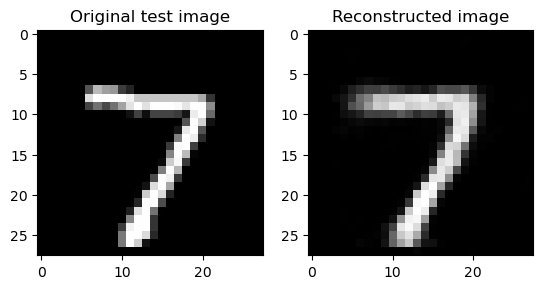

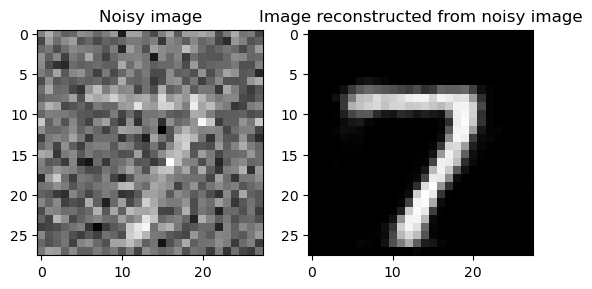

In [278]:
# Testing the model with normal and noisy images

# Load test data
data_test = DataLoader(dataset=mnist_test, batch_size = 50)
data_test_noise = DataLoader(dataset=mnist_test_noise, batch_size = 50)

output = []
for (image, _) in data_test:
    image = image.reshape(-1, 28*28)    # flattening the image
    reconstructed_image = model(image)  # Using the trained model for reconstruction of the image
    output.append(reconstructed_image)

output_noisy = []
for (image, _) in data_test_noise:
    image = image.reshape(-1, 28*28)    # flattening the image
    reconstructed_image = model(image)  # Using the trained model for reconstruction of the image
    loss = loss_function(reconstructed_image, image)
    output_noisy.append(reconstructed_image)

print('Loss (MSE) for test set (by model trained using noisy training data): ', loss.item())

# Plotting original and reconstructed image

# Plotting original image
fig, ax = plt.subplots(1, 2)
img, _ = mnist_test[0]
ax[0].imshow(img.numpy()[0], cmap='gray')
ax[0].set_title('Original test image')

# Plotting the reconstructed image
img = output[0]  
img = img.reshape(-1, 28, 28)     # Reshape the flattened image
ax[1].imshow(img.detach().numpy()[0], cmap='gray')
ax[1].set_title('Reconstructed image')

# Plotting original noisy image
fig, ax = plt.subplots(1, 2)
img, _ = mnist_test_noise[0]
ax[0].imshow(img.numpy()[0], cmap='gray')
ax[0].set_title('Noisy image')

# Plotting the reconstructed noisy image
img = output_noisy[0]  
img = img.reshape(-1, 28, 28)     # Reshape the flattened image
ax[1].imshow(img.detach().numpy()[0], cmap='gray')
ax[1].set_title('Image reconstructed from noisy image')

plt.show()

A new dataset called 'noisy_dataset' is created and it contains normal training images (50%) and noisy images (50%). Now, when the model the model is trained using this dataset, the MSE loss is high during the training phase, but the model is generalized to handle noisy images compared to previous case, where the model is trained only using normal images from MNIST training data. This is evident by comparing the MSE losses in both cases. MSE loss calculated for test set using only normal images for training is 0.6602, but when using mixture of noisy images and normal images for training, the MSE loss is 0.6555. Thus, the second model trained using 'noisy_dataset' performs well in test set. 

#### 4. Change the loss function of MSE with SSIM loss function. In other words, implement SSIM loss function yourself without using any libraries, in-built python functions. Explain the difference between them and compare the results. Please keep your loss function as MSE for the following questions.

In [279]:
# Defining SSIM loss function

def ssim_loss(img1, img2):
    img1 = img1.flatten()
    img2 = img2.flatten()

    N = len(img1)

    # Find mean value (luminence) of pixels of images
    mu1 = np.mean(img1)
    mu2 = np.mean(img2)

    # Find standard deviation (contrast) of pixels of images
    std1 = np.std(img1)
    std2 = np.std(img2)

    # Find covariance of img1 and img2

    cov = np.dot(img1 - mu1, img2 - mu2)/(N-1)

    # L - Dynamic range of pixel values (L = 1 for our case as pixel values range from 0 to 1)
    L = 1 

    # Let assign K1 = K2 = 1
    K1 = 1
    K2 = 1

    C1 = (K1*L)**2
    C2 = (K2*L)**2


    # Calculate SSIM from above parameters (Please refer the report for the formula)
    SSIM = ((2*mu1*mu2 + C1)*(2*cov + C2))/((mu1**2 + mu2**2 + C1)*(std1**2 + std2**2 + C2))

    # Return the loss value
    return 1 - SSIM

#### 5. Implement more complex autoencoder architecture to obtain better results. Provide improvements of the architecture. Visualize the results and compare with first architecture you implemented. Comment on the results.

Now let us implement a complex model, an Over-complete Auto-encoder that employs a higher number of hidden units than input dimensions. The idea behind using more hidden units is to learn a more complex, non-linear function that can better capture the structure of the data. Also, they are more robust to noise and can handle missing data better than traditional autoencoders

In [280]:
class Complex_Auto_Encoder(neuralnet.Module):
    def __init__(self):
        super().__init__()

        # Encoder architecture
        self.encoder = neuralnet.Sequential(
            # Input dimension: N, 28*28  N-> Number of images
            neuralnet.Linear(28*28, 1000),    # N, 784  -> N, 1000
            neuralnet.ReLU(),
            neuralnet.Linear(1000, 1000),     # N, 1000 -> N, 1000
            neuralnet.ReLU(),
            neuralnet.Linear(1000, 1000),     # N, 1000 -> N, 1000
            neuralnet.ReLU(),
            neuralnet.Linear(1000, 1000),     # N, 1000 -> N, 1000
        )   # Output dimension: N, 1000

        # Decoder architecture
        # Input dimension: N, 1000
        self.decoder = neuralnet.Sequential(
            neuralnet.Linear(1000, 1000),     # N, 1000  ->  N, 1000
            neuralnet.ReLU(),
            neuralnet.Linear(1000, 1000),     # N, 1000  ->  N, 1000
            neuralnet.ReLU(),
            neuralnet.Linear(1000, 1000),     # N, 1000  ->  N, 1000
            neuralnet.ReLU(),
            neuralnet.Linear(1000, 28*28),    # N, 1000 -> N, 784
            neuralnet.Sigmoid()
        )   # Output dimension: N, 28*28 

    def forward(self, data):
        encoded_data = self.encoder(data)
        decoded_data = self.decoder(encoded_data)
        return decoded_data

# Create an instance of our model and move it to corresponding pytorch device
complex_model = Complex_Auto_Encoder()


##### Training complex (Over-Complete) auto-encoder model using noisy training data  

Training using noisy training data: 
Epoch 1->
Loss (MSE): 0.17324961721897125
SSIM loss: 0.1381817811237448
Epoch 2->
Loss (MSE): 0.1797204315662384
SSIM loss: 0.13791819012479933
Epoch 3->
Loss (MSE): 0.16564436256885529
SSIM loss: 0.12700060314590866
Epoch 4->
Loss (MSE): 0.1753866821527481
SSIM loss: 0.13453969478375338
Epoch 5->
Loss (MSE): 0.16321927309036255
SSIM loss: 0.12413862246931517
Epoch 6->
Loss (MSE): 0.1495921015739441
SSIM loss: 0.11464935682301214
Epoch 7->
Loss (MSE): 0.13115815818309784
SSIM loss: 0.10178925726115573
Epoch 8->
Loss (MSE): 0.11992242187261581
SSIM loss: 0.09320663539975016
Epoch 9->
Loss (MSE): 0.1275462806224823
SSIM loss: 0.09957932643850798
Epoch 10->
Loss (MSE): 0.12406472861766815
SSIM loss: 0.09593711552834971


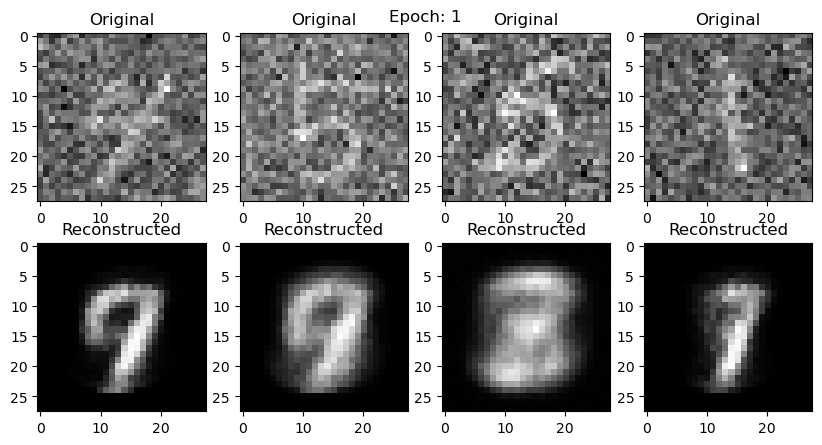

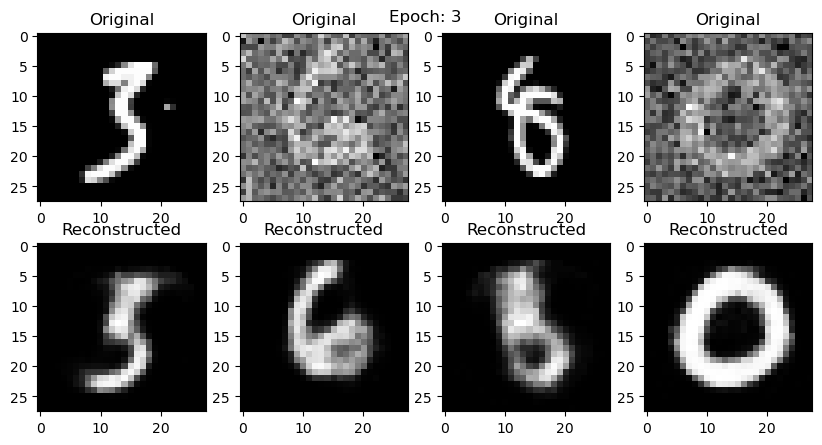

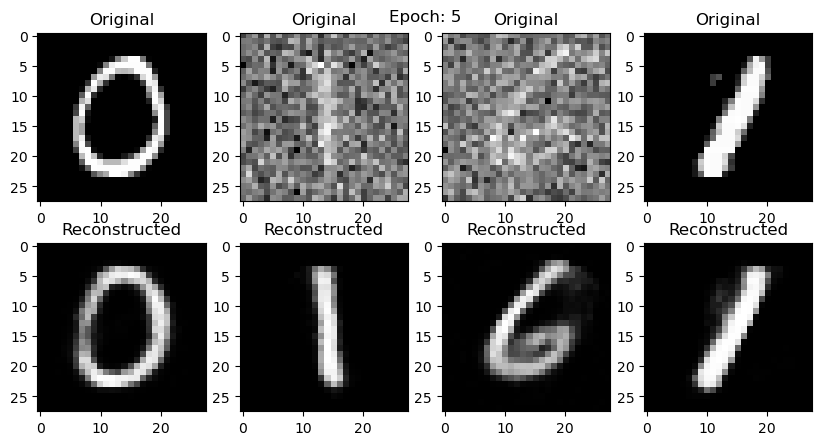

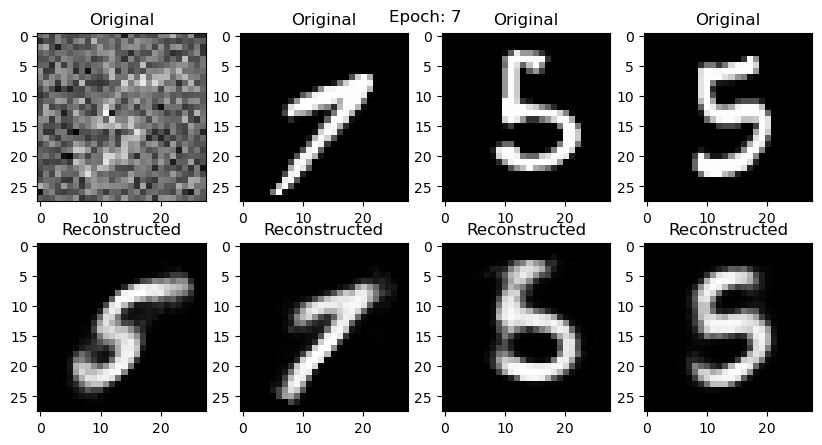

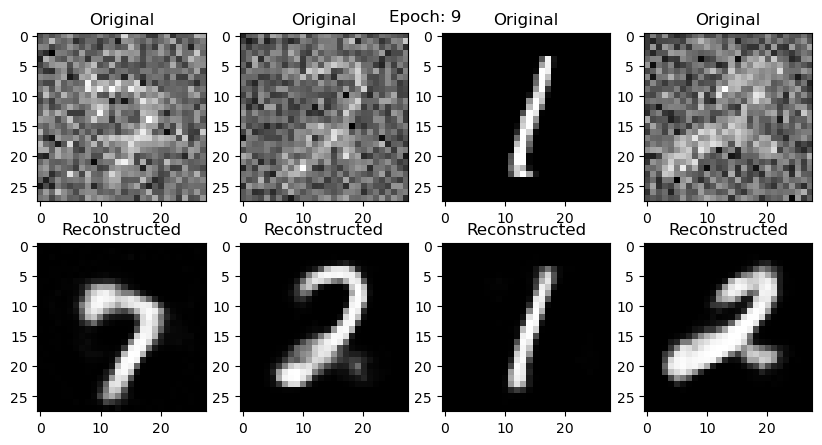

In [281]:
# Implement SGD
sgd = torch.optim.SGD(complex_model.parameters(), lr=1, momentum = 0.9)

# Choose MSE loss
loss_function = neuralnet.MSELoss()

# Define number of epochs over which the model has to be trained
epochs = 10

output = []
print('Training using noisy training data: ')
for epoch in range(epochs):
    for (image, _) in noisy_train:
        image = image.reshape(-1, 28*28)    # flattening the image
        processed_image = complex_model(image)
        loss = loss_function(processed_image, image)
        ssim = ssim_loss(processed_image.detach().numpy(), image.detach().numpy())

        sgd.zero_grad()
        loss.backward()
        sgd.step()
    
    print(f'Epoch {epoch+1}->')
    print(f'Loss (MSE): {loss.item()}')
    print(f'SSIM loss: {ssim}')
    output.append((epoch, image, processed_image))

# Plot original and reconstructed images generated by complex model for some epochs

for i in range(0, epochs, 2):
    plt.figure(figsize = (10,5))
    plt.gray()                              
    images = output[i][1].detach()
    reconstructed_images = output[i][2].detach()
    plt.gca().set_title(f'Epoch: {i+1}')
    plt.axis('off')
    
    #Plot original images
    for j, item in enumerate(images):
        if(j>=4):
            break
        plt.subplot(2, 4, j+1)
        plt.gca().set_title('Original')
        item = item.reshape(-1, 28, 28)     # Reshape the flattened image
        plt.imshow(item[0])    
    
    #Plot reconstructed image
    for j, item in enumerate(reconstructed_images):
        if(j>=4):
            break
        plt.subplot(2, 4, 4+j+1)
        plt.gca().set_title('Reconstructed')
        item = item.reshape(-1, 28, 28)     # Reshape the flattened image
        plt.imshow(item[0]) 
      

We can very well observe that the clarity of reconstructed images increases over epochs

##### Testing complex AE model with normal images

Loss (MSE) of complex_model for test set:  0.013671677559614182


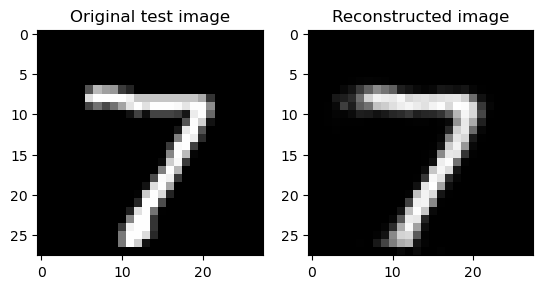

In [282]:
# Load test data
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform = transform_to_tensor)
data_test = DataLoader(dataset=mnist_test, batch_size = 50)

output = []
for (image, _) in data_test:
    image = image.reshape(-1, 28*28)    # flattening the image
    reconstructed_image = complex_model(image)  # Using the trained model for reconstruction of the image
    loss = loss_function(reconstructed_image, image)
    output.append(reconstructed_image)
print('Loss (MSE) of complex_model for test set: ', loss.item())


# Plotting samples of original and reconstructed image

# Plotting original image
fig, ax = plt.subplots(1, 2)
img, _ = mnist_test[0]
ax[0].imshow(img.numpy()[0], cmap='gray')
ax[0].set_title('Original test image')

# Plotting the reconstructed image
img = output[0]  
img = img.reshape(-1, 28, 28)     # Reshape the flattened image
ax[1].imshow(img.detach().numpy()[0], cmap='gray')
ax[1].set_title('Reconstructed image')
plt.show()


### 6. Implement the convolutional autoencoder model. Provide details of the architecture. Visualize the results and compare with basic and complex architectures you implemented. Comment on the results.

In [283]:
class Conv_Auto_Encoder(neuralnet.Module):
    def __init__(self):
        super().__init__()

        # Encoder architecture
        # Input dimension: N, 1, 28, 28
        self.encoder = neuralnet.Sequential(
            neuralnet.Conv2d(1, 16, 2, stride=2, padding=2),    # N, 16, 16, 16
            neuralnet.ReLU(),
            neuralnet.Conv2d(16, 32, 3, stride=2, padding=1),   # N, 32, 8, 8
            neuralnet.ReLU(),
            neuralnet.Conv2d(32, 64, 8)                         # N, 64, 1, 1
        )   # Output dimension: N, 64, 1, 1

        # Decoder architecture
        # Input dimension: N, 64, 1, 1
        self.decoder = neuralnet.Sequential(
            neuralnet.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            neuralnet.ReLU(),
            neuralnet.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            neuralnet.ReLU(),
            neuralnet.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # N, 1, 28, 28  (N,1,27,27)
            neuralnet.Sigmoid()
        )   # Output dimension: N, 1, 28, 28


    def forward(self, data):
        encoded_data = self.encoder(data)
        decoded_data = self.decoder(encoded_data)
        return decoded_data

# Create an instance of our model and move it to corresponding pytorch device
conv_model = Conv_Auto_Encoder()



Training using noisy training data: 
Epoch 1, Loss (MSE): 0.21570822596549988
Epoch 2, Loss (MSE): 0.18434013426303864
Epoch 3, Loss (MSE): 0.16501928865909576
Epoch 4, Loss (MSE): 0.13802778720855713
Epoch 5, Loss (MSE): 0.10681120306253433
Epoch 6, Loss (MSE): 0.13887600600719452
Epoch 7, Loss (MSE): 0.12277913093566895
Epoch 8, Loss (MSE): 0.12347076833248138
Epoch 9, Loss (MSE): 0.15079191327095032
Epoch 10, Loss (MSE): 0.12728117406368256


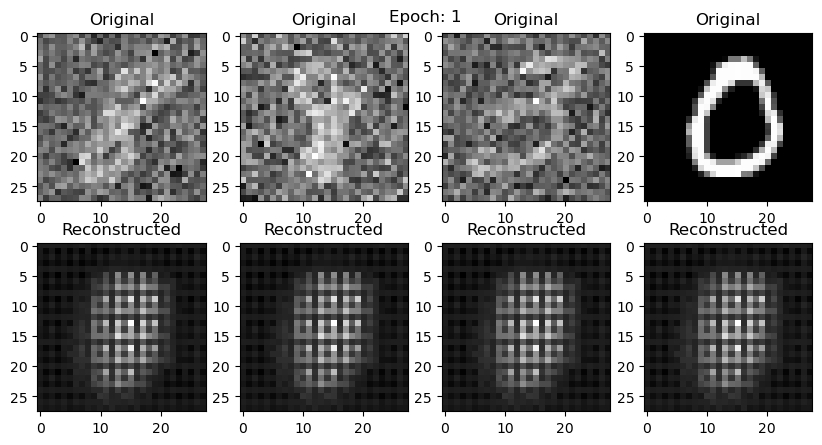

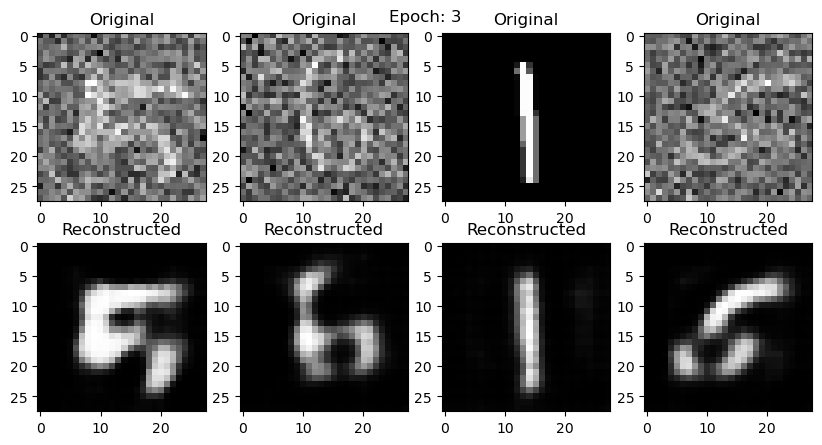

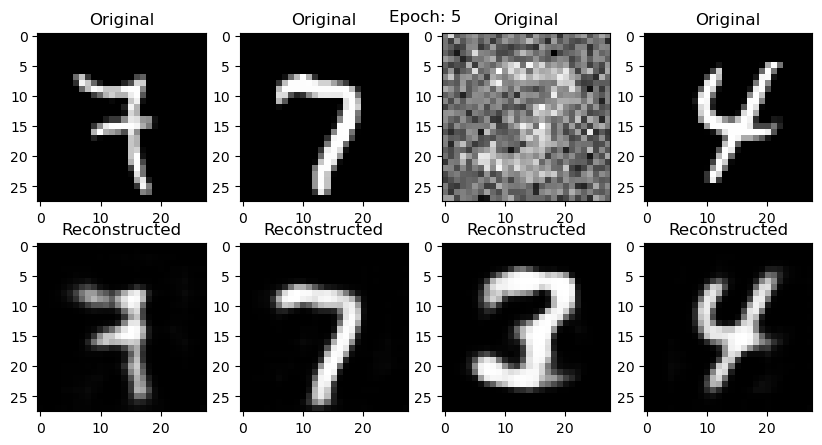

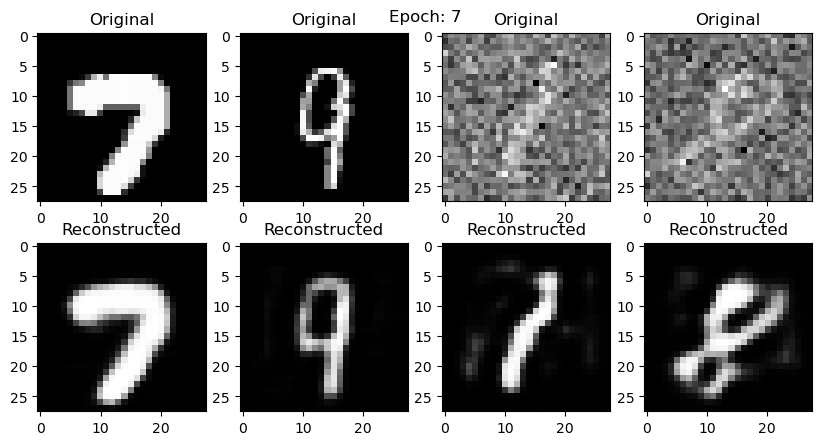

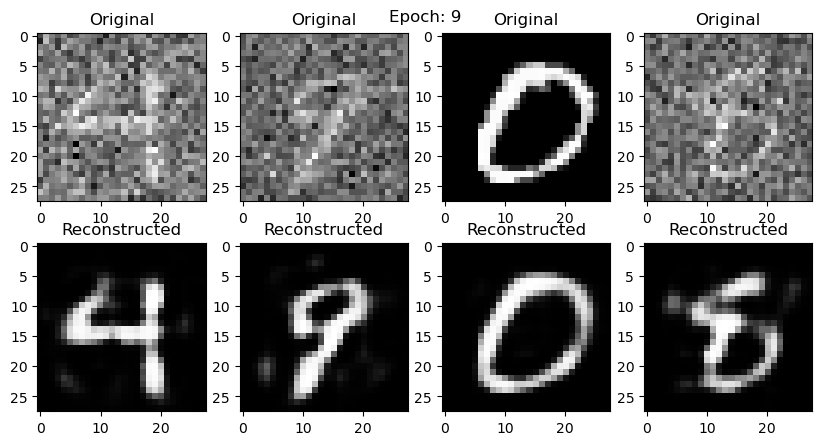

In [284]:
# Train the CNN auto-encoder using noisy training data

# SGD for optimization and MSE for loss
sgd = torch.optim.SGD(conv_model.parameters(), lr=1)
loss_function = neuralnet.MSELoss()

# Define number of epochs over which the Convolutional model has to be trained
epochs = 10

output = []
print('Training using noisy training data: ')
for epoch in range(epochs):
    for (image, _) in noisy_train:
        reconstructed_image = conv_model(image)
        loss = loss_function(reconstructed_image, image)
        sgd.zero_grad()
        loss.backward()
        sgd.step()
    
    print(f'Epoch {epoch+1}, Loss (MSE): {loss.item()}')
    output.append((epoch, image, reconstructed_image))

# Plot original and reconstructed images generated by Convolutional model for some epochs

for i in range(0, epoch+1, 2):
    plt.figure(figsize = (10,5))
    plt.gray()                              
    images = output[i][1].detach()
    reconstructed_images = output[i][2].detach()
    plt.gca().set_title(f'Epoch: {i+1}')
    plt.axis('off')
    
    #Plot original images
    for j, item in enumerate(images):
        if(j>=4):
            break
        plt.subplot(2, 4, j+1)
        plt.gca().set_title('Original')
        plt.imshow(item[0])    
    
    #Plot reconstructed image
    for j, item in enumerate(reconstructed_images):
        if(j>=4):
            break
        plt.subplot(2, 4, 4+j+1)
        plt.gca().set_title('Reconstructed')
        plt.imshow(item[0])  
  

Loss (MSE) of convolutional model on test set:  0.004205716773867607


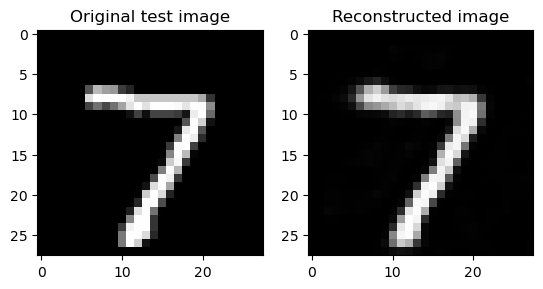

In [285]:
# Testing the CNN model with normal images

# Load test data
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform = transform_to_tensor)
data_test = DataLoader(dataset=mnist_test, batch_size = 50)

output = []
for (image, _) in data_test:
    # Image flattening not required for CNN
    reconstructed_image = conv_model(image)  # Using the trained model for reconstruction of the image
    loss = loss_function(reconstructed_image, image)
    output.append(reconstructed_image)
    
print('Loss (MSE) of convolutional model on test set: ', loss.item())

# Plotting samples of original and reconstructed image

# Plotting original image
fig, ax = plt.subplots(1, 2)
img, _ = mnist_test[0]
ax[0].imshow(img.numpy()[0], cmap='gray')
ax[0].set_title('Original test image')

# Plotting the reconstructed image
img = output[0][0][0]
ax[1].imshow(img.detach().numpy(), cmap='gray')
ax[1].set_title('Reconstructed image')
plt.show()


We can observe that the quality of reconstructed image is continiously increasing with epochs. The reconsturcted images in the final epochs is more or less similar to original image. Also, compared to other two (Linear and Complex AE models) the Convolutional Auto-encoder performs well during testing phase. 

### 7. Choose the best implementation of them based on the accuracy results by explaining the reason for that decision. Plot the training and validation loss functions of your best architecture to epoch numbers. What is overfitting? How can one detect and avoid over-fitting? Please answer the rest of the questions based on the best implementation.

Training using noisy training dataset: 
Epoch 1, Training Loss: 0.2448476105928421, Validation Loss: 0.24311119318008423
Epoch 2, Training Loss: 0.16010713577270508, Validation Loss: 0.21092410385608673
Epoch 3, Training Loss: 0.15138362348079681, Validation Loss: 0.16352178156375885
Epoch 4, Training Loss: 0.10806052386760712, Validation Loss: 0.15696780383586884
Epoch 5, Training Loss: 0.13874100148677826, Validation Loss: 0.1538802981376648
Epoch 6, Training Loss: 0.137968972325325, Validation Loss: 0.15231665968894958
Epoch 7, Training Loss: 0.1456638127565384, Validation Loss: 0.15082111954689026
Epoch 8, Training Loss: 0.11829935759305954, Validation Loss: 0.14620159566402435
Epoch 9, Training Loss: 0.11260433495044708, Validation Loss: 0.14568428695201874
Epoch 10, Training Loss: 0.11102057248353958, Validation Loss: 0.1446569263935089
Epoch 11, Training Loss: 0.11684256047010422, Validation Loss: 0.14612191915512085
Epoch 12, Training Loss: 0.15396200120449066, Validation Loss:

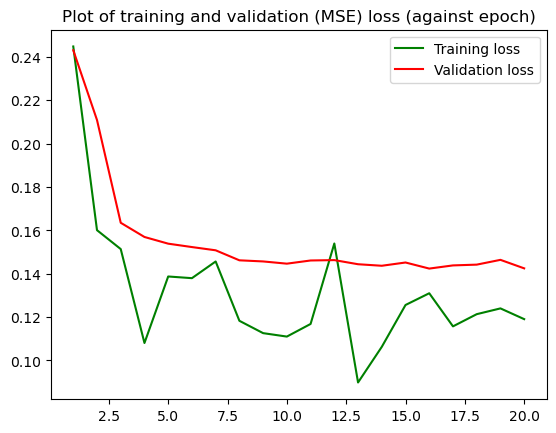

In [286]:
# Randomly split noisy training data into training and validation sets (in a ratio 80:20)
train_data , val_data = torch.utils.data.random_split(noisy_dataset, [50000, 10000])

# Split the training and validation data into mini-batches along with shuffling (to prevent over-fitting) using DataLoader iterable
batch_size = 50     # Setting up batch size
data_train = DataLoader(dataset=train_data, batch_size = batch_size, shuffle= True)
data_val = DataLoader(dataset=val_data, batch_size = batch_size, shuffle= False)

# Create instance of the convolutional model
conv_model = Conv_Auto_Encoder()

# Initilize optimizer and loss functions
sgd = torch.optim.SGD(conv_model.parameters(), lr=1)
loss_function = neuralnet.MSELoss()

# Define number of epochs over which the Convolutional model has to be trained
epochs = 20

output = []
training_loss = []
validation_loss = []
print('Training using noisy training dataset: ')
for epoch in range(epochs):
    for (image, _) in data_train:
        reconstructed_image = conv_model(image)
        train_loss = loss_function(reconstructed_image, image)
        sgd.zero_grad()
        train_loss.backward()
        sgd.step()
    for (val_image, _) in data_val:
        reconstructed_val_image = conv_model(val_image)
        val_loss = loss_function(reconstructed_val_image, val_image)
    
    print(f'Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}')
    training_loss.append(train_loss.item())
    validation_loss.append(val_loss.item())
    output.append((epoch, image, reconstructed_image))

# Plot training and validation loss against epoch
x = [epoch for epoch in range(1,epochs+1)]
plt.plot(x, training_loss, 'g')
plt.plot(x, validation_loss, 'r')
plt.legend(["Training loss", "Validation loss"])
plt.title("Plot of training and validation (MSE) loss (against epoch)")
plt.show()    


#### 8. Decide a threshold value in reconstruction error for detecting outliers (corrupted images) by drawing the loss distribution for normal and corrupted images. This threshold value needs to be used to determine whether the input sample is an anomaly or not. Then, explain why you decided on that threshold value by comparing it with other threshold values.

Mean of loss for normal images: 0.0037481423548888417   Mean of loss for normal images: 0.24453787866979837
Mean of loss for normal images: 0.004660069011151791
Threshold value chosen: 0.0055719956674147395


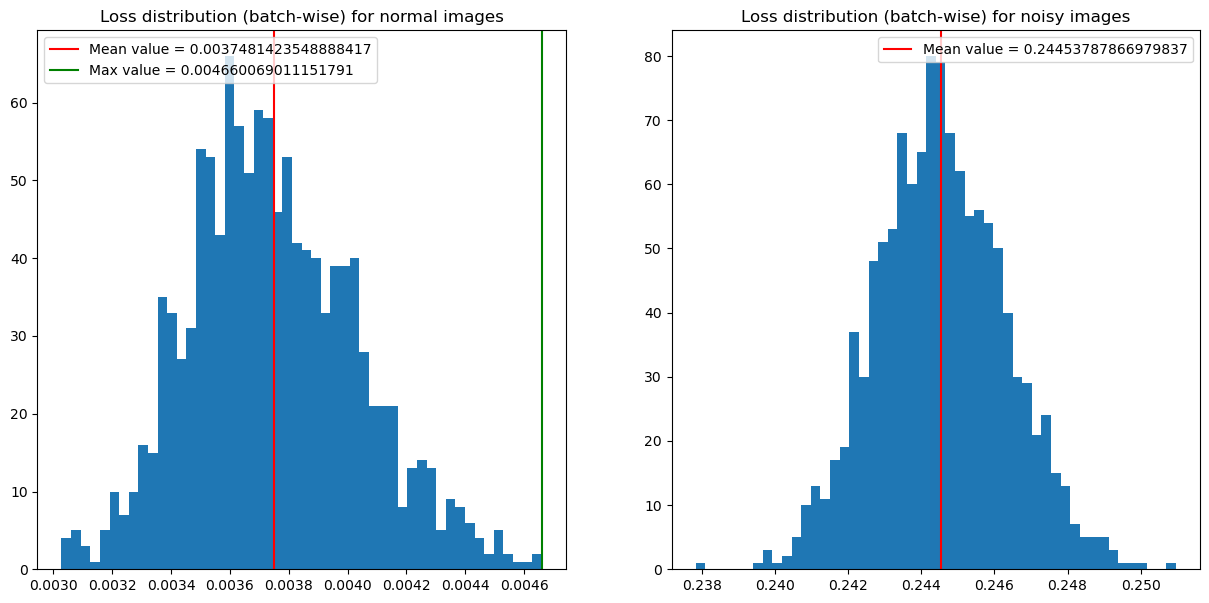

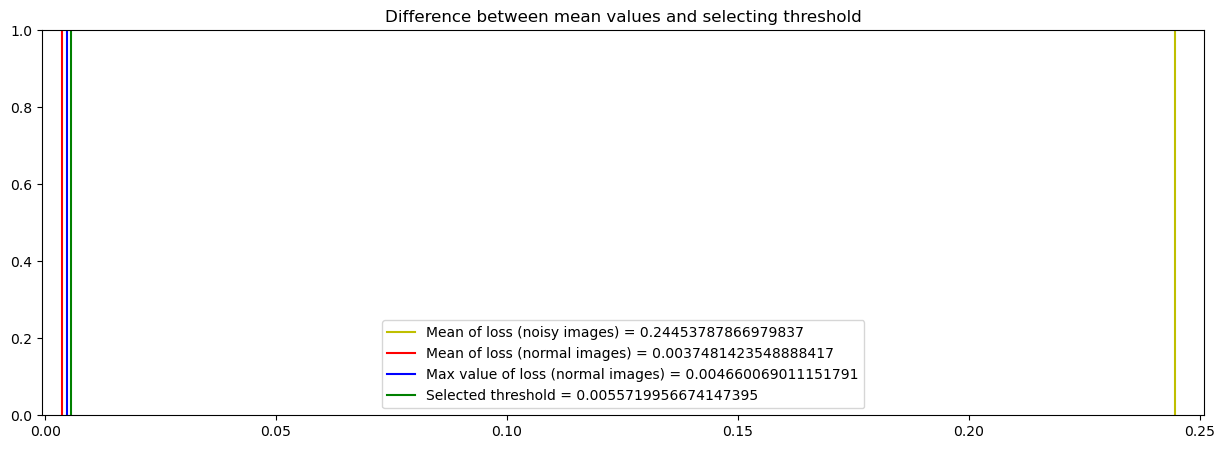

In [287]:
mnist_train = datasets.MNIST(root='./data', train= True, download = False, transform = transform_to_tensor)
mnist_train_noisy = datasets.MNIST(root='./data', train=True, download=False, transform = noise_transform) 

batch_size = 50
train_noisy_data = DataLoader(dataset=mnist_train_noisy, batch_size = batch_size, shuffle= True)
train_data = DataLoader(dataset=mnist_train, batch_size = batch_size, shuffle= True)

loss_noisy = []
loss_normal = []

for (image, _) in train_data:
    # Image flattening not required for CNN
    reconstructed_image = conv_model(image)  # Using the trained model for reconstruction of normal image
    loss = loss_function(reconstructed_image, image)
    loss_normal.append(loss.item())
    
for (image, _) in train_noisy_data:
    # Image flattening not required for CNN
    reconstructed_image = conv_model(image)  # Using the trained model for reconstruction of noisy image
    loss = loss_function(reconstructed_image, image)
    loss_noisy.append(loss.item())   


# Selecting threshold value (Value slightly above the max loss value for normal image)
threshold = max(loss_normal) + (max(loss_normal) - np.mean(loss_normal))

print(f'Mean of loss for normal images: {np.mean(loss_normal)}   Mean of loss for normal images: {np.mean(loss_noisy)}')
print(f'Mean of loss for normal images: {max(loss_normal)}')
print(f'Threshold value chosen: {threshold}')

# Plot loss distribution for normal and corrupted images
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].hist(loss_normal, bins=50)
ax[0].axvline(x =np.mean(loss_normal), color = 'r', label = 'Mean value = {}'.format(np.mean(loss_normal)))
ax[0].axvline(x =np.max(loss_normal), color = 'g', label = 'Max value = {}'.format(max(loss_normal)))
ax[0].legend()
ax[0].title.set_text('Loss distribution (batch-wise) for normal images')
ax[1].hist(loss_noisy, bins=50)
ax[1].axvline(x =np.mean(loss_noisy), color = 'r', label = 'Mean value = {}'.format(np.mean(loss_noisy)))
ax[1].legend()
ax[1].title.set_text('Loss distribution (batch-wise) for noisy images')
plt.show()  

fig, ax = plt.subplots(1, figsize=(15, 5))
plt.xlim(min(loss_normal)-np.mean(loss_normal), max(loss_noisy))
ax.axvline(x =np.mean(loss_noisy), color = 'y', label = "Mean of loss (noisy images) = {}".format(np.mean(loss_noisy)))
ax.axvline(x =np.mean(loss_normal), color = 'r', label = 'Mean of loss (normal images) = {}'.format(np.mean(loss_normal)))
ax.axvline(x =np.max(loss_normal), color = 'b', label = 'Max value of loss (normal images) = {}'.format(max(loss_normal)))
ax.axvline(x = threshold, color = 'g', label = 'Selected threshold = {}'.format(threshold))
ax.legend()
ax.title.set_text("Difference between mean values and selecting threshold")
plt.show()    



From the plots, we can see that there is large difference between the MSE loss (mean) values for normal and noisy images. But this gap may reduce if we reduce the Gaussian noise by varying the parameters (mean and variance).
In order to detect anomalies, we can choose a threshold value that is slightly greater than the maximum loss value for normal images. For the current run, the threshold value is given below and also can be vizualized in above graph.

In [288]:
print(f'Threshold value chosen: {threshold}')

Threshold value chosen: 0.0055719956674147395


### Below is the code to get the model summaries

In [289]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Summary of simple Linear Auto-encoder")
simple_model = Auto_Encoder().to(device)
print(summary(simple_model, (1, 28*28)))
print()

print("Summary of Complex Auto-Encoder")
complex_mdl = Complex_Auto_Encoder().to(device)
print(summary(complex_mdl, (1, 28*28)))
print()

print("Model summary of Convolutional Auto-Encoder")
convolutional_model = Conv_Auto_Encoder().to(device)
print(summary(convolutional_model, (1, 28, 28)))


Summary of simple Linear Auto-encoder
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3                [-1, 1, 64]          16,448
              ReLU-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 8]             520
            Linear-6                [-1, 1, 64]             576
              ReLU-7                [-1, 1, 64]               0
            Linear-8               [-1, 1, 256]          16,640
              ReLU-9               [-1, 1, 256]               0
           Linear-10               [-1, 1, 784]         201,488
          Sigmoid-11               [-1, 1, 784]               0
Total params: 436,632
Trainable params: 436,632
Non-trainable params: 0
---------------------------------------------------------